In [ ]:
# !pip install umap-learn
# !pip uninstall umap -y

In [1]:
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#tensorflow 2.6 kernel

In [3]:
import importlib

import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils

import matplotlib.pyplot as plt


In [4]:
import time
import numpy as np

import data_utils
import data_utils_new
import losses

from IPython import display

In [5]:
# import umap

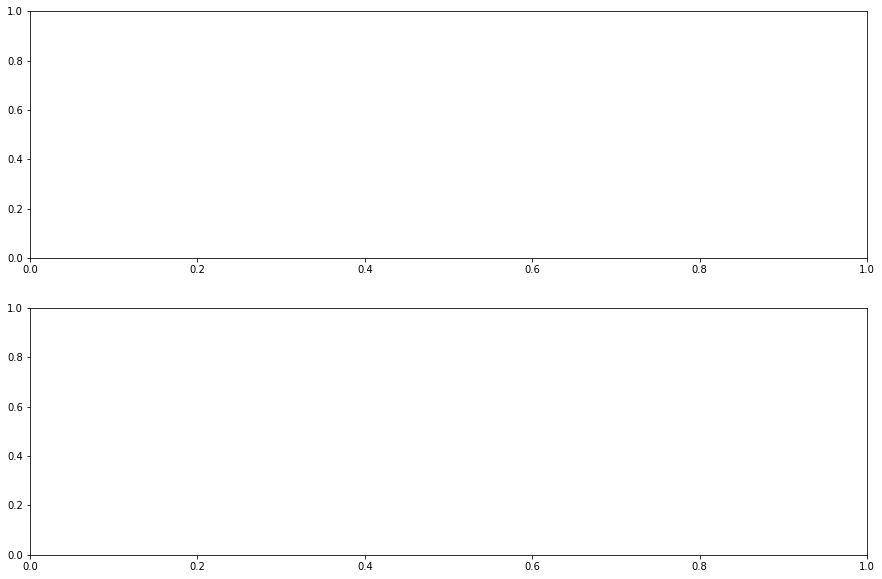

In [8]:
backbone = 'vgg16'
dataset = "SYNTHIA_VIPER_DENSE_13_1"

# H x W x C
img_shape = (512,1024,3)

# 13 classes + void
num_classes = 14

batch_size=4

do_training = True

epochs=100000
epoch_step=250

num_projections=100


import math 
fig, ax=plt.subplots(2, figsize=(15,10))

source_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/SYNTHIA/train/'
cityscapes_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/'

fn_w_dlv3 = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone + "_deeplabv3.h5"
fn_w_cls = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone + "_deeplabv3_classifier.h5"

fn_w_adapted_dlv3 = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone +"_deeplabv3_adapted.h5"
fn_w_adapted_cls = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone + "_deeplabv3_classifier_adapted.h5"

In [9]:
print(fn_w_dlv3)
print(fn_w_adapted_dlv3)

/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3.h5
/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5


In [10]:
importlib.reload(losses)

deeplabv3 = dlv3.deeplabv3(activation=None, \
                           backbone=backbone, \
                           num_classes=num_classes)

X = deeplabv3.input
Y = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,), dtype='float32', name='label_input')

C_in = tf.keras.layers.Input(shape=deeplabv3.layers[-1].output_shape[1:], dtype='float32', name='classifier_input')
classifier = tf.keras.Model(C_in, networks.classifier_layers(C_in, num_classes = num_classes, activation='softmax'))

# A combined model, giving the output of classifier(deeplabv3(X))
combined = tf.keras.Model(X, classifier(deeplabv3(X)))
combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# A model outputting hxwx1 labels for each image. Also useful to verify the
# mIoU with Keras' built-in function. Will however also consider the 'ignore' class. 
combined_ = tf.keras.Model(X, tf.cast(tf.keras.backend.argmax(combined(X), axis=-1), 'float32'))
combined_.compile(metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)], loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# Set up training
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-8, decay=1e-6)
# opt = tf.keras.optimizers.SGD(lr=1e-4, momentum=.9)

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y, classifier(deeplabv3(X)), from_logits=False)

# https://stackoverflow.com/questions/55434653/batch-normalization-doesnt-have-gradient-in-tensorflow-2-0
params = deeplabv3.trainable_weights + classifier.trainable_weights

updates = opt.get_updates(wce_loss, params)

train = tf.keras.backend.function(inputs=[X,Y], outputs=[wce_loss], updates=updates)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# deeplabv3.load_weights(fn_w_dlv3)
# classifier.load_weights(fn_w_cls)

In [10]:
# import matplotlib.pyplot as plt 
# importlib.reload(data_utils)

# do_training = True

# # Training on source domain
# if do_training == True:
#     try:
#         deeplabv3.load_weights(fn_w_dlv3)
#         classifier.load_weights(fn_w_cls)

#         print("Successfully loaded model. Continuing training.")
#     except:
#         print("Could not load previous model weights. Is a new model present?")
        
#     start_time = time.time()

#     fig,ax = plt.subplots(1,figsize=(10,7))

#     loss_history = []

#     for itr in range(epochs):
#     # for itr in range(1):
#         source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=batch_size, seed=itr)
#         source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

#         loss_history.append(train(inputs=[source_train_data, source_train_labels ]))

#         if np.isnan(np.sum(loss_history[-1])):
#             print('ERROR. ENCOUNTERED NAN')
#             break

#         if itr%epoch_step == 0:
#             if itr != 0:
#                 ax.clear()
#                 ax.plot(np.asarray(loss_history))

#             ax.set_title("Training loss on source domain")
#             ax.set_xlabel("Epoch")
#             ax.set_ylabel("Loss")

#             display.clear_output(wait=True)
#             display.display(plt.gcf())
#             time.sleep(1e-3)
            
#         if itr % (epochs // 10) == 0 or itr == epochs - 1:
#             deeplabv3.save_weights(fn_w_dlv3)
#             classifier.save_weights(fn_w_cls)

#     training_time = time.time() - start_time
# else:
#     deeplabv3.load_weights(fn_w_dlv3)
#     classifier.load_weights(fn_w_cls)
#     print("Loaded model weights")

In [11]:
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

## Performance before adaptation

In [ ]:
import utils
importlib.reload(utils)

import data_utils_new

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils_new.label_ids_13, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)


# road 0.8615078545158885
# sidewalk 0.9000774695735323
# building 0.9430844244367906
# traffic light 0.5906543878603067
# traffic sign 0.47512503948229323
# vegetation 0.8432760653705371
# sky 0.9643722032928421
# person 0.7238042430944608
# rider 0.6191497998404211
# car 0.882677391642491
# bus 0.911323854999263
# motorcycle 0.6885880663029611
# bicycle 0.34777010181426876
# 0.7501085309404659
# Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 3522.347924232483

In [18]:
importlib.reload(utils)

start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils_new.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed VIPER mIoU in', time.time() - start_time)

# road 0.46610276620252705
# sidewalk 0.08673575303732681
# building 0.47584591747660204
# traffic light 0.09605701550329426
# traffic sign 0.014402255800938481
# vegetation 0.13339936275003222
# sky 0.7302335987742893
# person 0.19711547556738282
# rider 0.0
# car 0.8627417161587038
# bus 0.01936740214450999
# motorcycle 0.0
# bicycle 0.0
# 0.237077020262739
# Computed VIPER mIoU in 166.7798900604248

### Load pretrained weights for SYNTHIA

In [9]:
deeplabv3.load_weights("/pscratch/sd/c/chubakov/code/mas3-continual/weights/SYNTHIA_VIPER_DENSE_13_3/vgg16_deeplabv3_adapted.h5")
classifier.load_weights("/pscratch/sd/c/chubakov/code/mas3-continual/weights/SYNTHIA_VIPER_DENSE_13_3/vgg16_deeplabv3_classifier_adapted.h5")
print("Loaded model weights")

Loaded model weights


In [ ]:
import data_utils_new
importlib.reload(utils)

start_time = time.time()
means, _, ct = utils.learn_gaussians(source_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13)
print("computed means in", time.time() - start_time)

start_time = time.time()
means, covs, ct = utils.learn_gaussians(source_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13, \
                                  initial_means=means)
print("finished training gaussians in", time.time() - start_time)

np.save("./extras/means_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy", means)
np.save("./extras/covs_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy", covs)

In [ ]:
for i in range(means.shape[0]):
    print('=====================================================')
    print(means[i])
    print(covs[i])


In [ ]:
# means = np.load("./extras/means_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy")
# covs = np.load("./extras/covs_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy")

# means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")
# covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")

In [10]:
# SYNTHIA -> VIPER1
means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")

means = np.nan_to_num(means)

In [9]:
means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")

In [10]:
# means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")
# covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")
means = np.nan_to_num(means)
# means

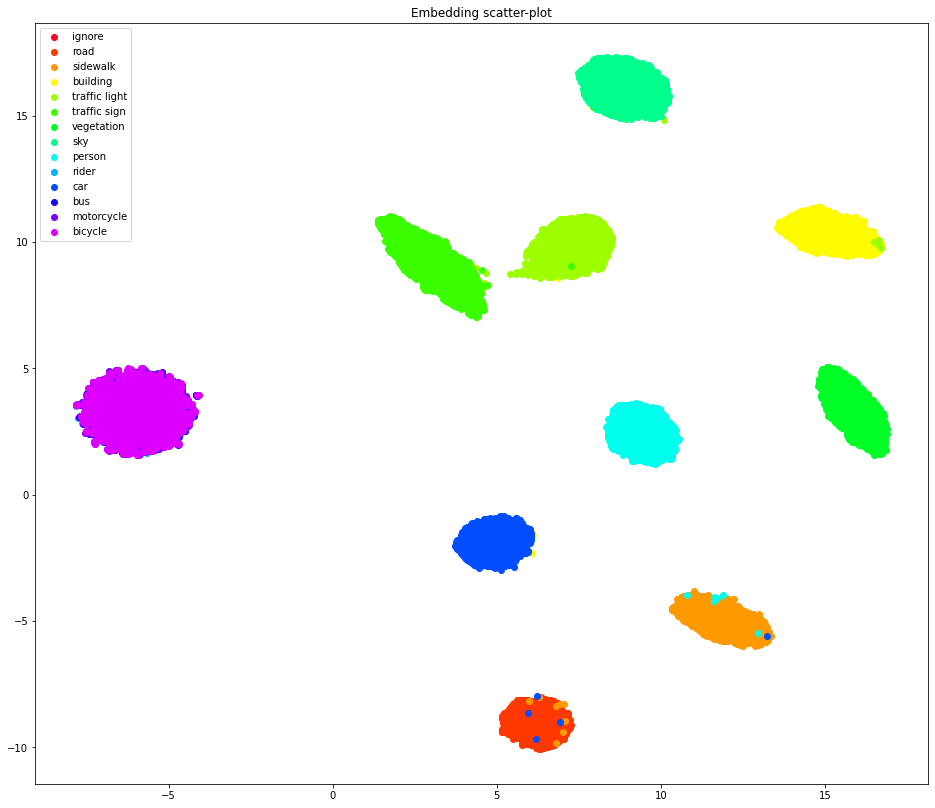

18.559155464172363


In [11]:
import data_utils_new
import matplotlib.pyplot as plt 
import umap.umap_ as umap
# Generate data from the gmm model and plot it

start_time = time.time()

n_samples = np.ones(num_classes, dtype=int)
n_samples[0] = 0
n_samples *= 2000

xx, yy = utils.sample_from_gaussians(means, covs, n_samples=n_samples)

NUM_COLORS = num_classes

reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(xx)

plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(data_utils_new.label_ids_13.keys())
idx = 0
for label in data_utils_new.label_ids_13:
    ind = yy == data_utils_new.label_ids_13[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()

print(time.time() - start_time)

In [11]:
importlib.reload(wasserstein_utils)

Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,) )
Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') #labels of input images oneHot
lambda2 = 5e-1

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y_s, classifier(Z_s), from_logits=False)

# Wasserstein matcing loss
theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), Z_s, theta, nclass=num_classes, Cp=None, Cq=None,)

# Overall loss is a weighted combination of the two losses
total_loss = wce_loss + lambda2*matching_loss

params = deeplabv3.trainable_weights + classifier.trainable_weights

# Optimizer and training setup
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)

updates = opt.get_updates(total_loss, params)
train = tf.keras.backend.function(inputs=[X,Z_s,Y_s,theta], outputs=[total_loss, wce_loss, matching_loss], updates=updates)

/global/cscratch1/sd/saksman/accda_conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
loss = []
target_miou = []

# deeplabv3.load_weights(fn_w_dlv3)
# classifier.load_weights(fn_w_cls)

In [13]:
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

Loaded model weights


## Initial SYNTHIA->VIPER adaptation

mIoU at 7 epochs: 0.04392110384427584
Iteration: 8
mIoU at 8 epochs: 0.006518378423956724


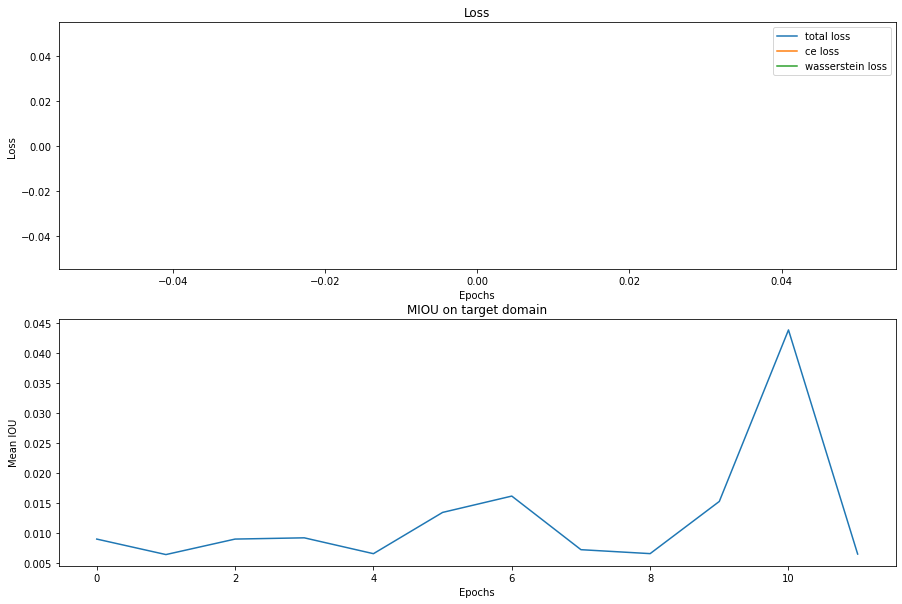

In [ ]:
fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 1

thres = .99
epochs2 = 50000
epochs2 = 2000
epochstep = 2

# load model weights
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

# load replay buffer params
means = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
covs = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
print("Loaded means and covariances for replay buffer")

for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # print(target_train_data.shape)

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)


    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    
    # print('source shape: ',Yembed.shape)
    

    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    # print(Yembed.shape)

    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, theta_instance]))
    miou = combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    print("mIoU at {0} epochs: {1}".format(itr, miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 

### Performance after adaptation

In [ ]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_13, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# VIPER 1
# road 0.45548384569118733
# sidewalk 0.22908076309616884
# building 0.7231414831527551
# traffic light 0.13056876105257134
# traffic sign 0.10746477632561094
# vegetation 0.29910880116931143
# sky 0.7702276075574622
# person 0.3968236052300994
# rider 0.0012631338117709702
# car 0.3250214488701445
# bus 0.011364789604663108
# motorcycle 0.0014075893390935838
# bicycle 0.0013295668128586176
# 0.26556047474720745
# Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 701.9752759933472


In [ ]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed VIPER mIoU in', time.time() - start_time)

# VIPER-1
# road 0.8170088043832361
# sidewalk 0.33026286655816334
# building 0.632127644160952
# traffic light 0.4009491872069492
# traffic sign 0.006254310466994813
# vegetation 0.1306418583589563
# sky 0.8650156523569378
# person 0.19010653822990375
# rider 0.0
# car 0.8404013262102543
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.32405909137941136
# Computed VIPER mIoU in 18.68591570854187

# VIPER-2
# road 0.6166949852470773
# sidewalk 0.3787735571503562
# building 0.6049256780597033
# traffic light 0.186964255325101
# traffic sign 0.0008168001712463807
# vegetation 0.09151754024216284
# sky 0.8323521128681671
# person 0.47658649376653717
# rider 0.0
# car 0.8210425378196808
# bus 0.3683831960382732
# motorcycle 0.0
# bicycle 0.0
# 0.33677362743756195
# Computed VIPER 2 mIoU in 12.673284530639648

# VIPER-3
# road 0.7241212757775349
# sidewalk 0.20394133957802926
# building 0.4374052246162175
# traffic light 0.1886698588396244
# traffic sign 0.0013552072158326775
# vegetation 0.23934770268178143
# sky 0.8418698288550998
# person 1.9359460000129065e-05
# rider 0.0
# car 0.8522794354467441
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.26838532557468187
# Computed VIPER 3 mIoU in 9.569716215133667

# VIPER-4




In [ ]:
import utils
importlib.reload(utils)

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_4/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_4/vgg16_deeplabv3_classifier_adapted.h5')

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')

start_time = time.time()
source_cat_iou,source_miou = utils.compute_miou('./processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence010/', combined_, data_utils.label_ids_13, 0)
for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

In [24]:
import utils
importlib.reload(utils)

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_classifier_adapted.h5')


# deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
# classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')

for target_i in range(1,11):
    target_data_dir = './processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i).rjust(3, '0') + '/'
    source_cat_iou,source_miou = utils.compute_miou(target_data_dir, combined_, data_utils.label_ids_13, 0)
    # for k in source_cat_iou:
    #     print(k, source_cat_iou[k])
    print(target_i, '\t : \t', source_miou)


1 	 : 	 0.3304527332435952
2 	 : 	 0.33019344797055583
3 	 : 	 0.2819066622949565
4 	 : 	 0.31654615749708054
5 	 : 	 0.3073701739865
6 	 : 	 0.3069781458418397
7 	 : 	 0.2667288525194096
8 	 : 	 0.24169105277904077
9 	 : 	 0.27019105419790657
10 	 : 	 0.24983465619512438


Iteration: 100


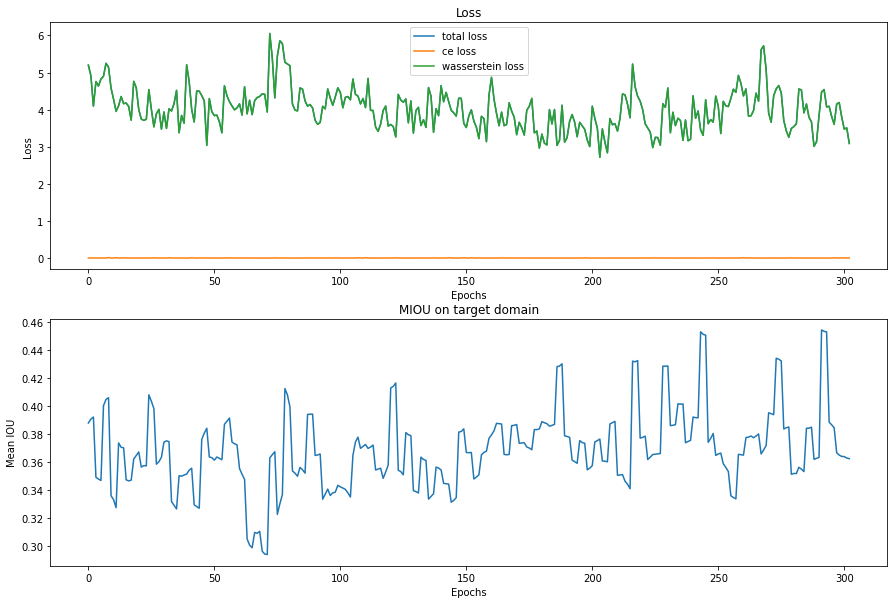

In [ ]:
import data_utils_new
importlib.reload(utils)

dataset = "SYNTHIA_VIPER_DENSE_13_"

fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 4

thres = .99
epochs_target = 500
epochstep = 100

target_means = []
target_covs = []

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_classifier_adapted.h5')
print("Loaded model weights")

log_f = open("log.txt", "a")

starting_target = 2

# if starting_target > 2:

#     for target_i in range(2, starting_target):

#         print('generating stats for target {}'.format(target_i))

#         fn_w_adapted_dlv3 = "weights/" + dataset + str(target_i) + "/" + backbone +"_deeplabv3_adapted.h5"
#         fn_w_adapted_dlv3 = "weights/" + dataset + str(target_i) + "/" + backbone + "_deeplabv3_classifier_adapted.h5"

#         deeplabv3.load_weights(fn_w_adapted_dlv3)
#         classifier.load_weights(fn_w_adapted_dlv3)    

#         # learn gaussians for the previous target domain   
#         start_time = time.time()
#         cur_means, _, cur_ct = utils.learn_gaussians_seq(prev_target_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13)
#         print("computed means in for target {}".format(target_i), time.time() - start_time)

#         start_time = time.time()
#         cur_means, cur_covs, cur_ct = utils.learn_gaussians_seq(prev_target_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13, initial_means=cur_means)
#         print("finished training gaussians in", time.time() - start_time)

#         cur_means = np.nan_to_num(cur_means)

#         target_means.append(cur_means)
#         target_covs.append(cur_covs)

for target_i in range(starting_target, 10):   
        
    prev_target_data_dir = './processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i-1).rjust(3, '0') + '/'
    target_data_dir = './processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i).rjust(3, '0') + '/'
    
    print('adapting to target domain {}'.format(target_i), '\t', prev_target_data_dir, '\t', target_data_dir)
        
    # learn gaussians for the previous target domain   
    start_time = time.time()
    cur_means, _, cur_ct = utils.learn_gaussians_seq(prev_target_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13)
    print("computed means in for target {}".format(target_i), time.time() - start_time)

    start_time = time.time()
    cur_means, cur_covs, cur_ct = utils.learn_gaussians_seq(prev_target_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13, initial_means=cur_means)
    print("finished training gaussians in", time.time() - start_time)

    cur_means = np.nan_to_num(cur_means)
    
    target_means.append(cur_means)
    target_covs.append(cur_covs)
    
    loss = []
    target_miou = []
    
    cur_epochs = max(epochs_target, epochs_target // (target_i - 1))
    print('number of epochs for current iter : ', cur_epochs) 
         
    for itr in range(epochs_target):
    
        if itr%epochstep == 0:
            print('Iteration: {}'.format(itr))
            
        # target_samples_X = []
        # target_samples_Y = []
        # rb_samples_X = []
        # rb_samples_Y = []

        
        for prev_target in range(0, target_i-1):            
           
            # target_train_data, target_train_labels = utils.sample_batch(target_data_dir, batch_size=batch_size, seed=itr)
            target_train_data, target_train_labels = utils.sample_batch(target_data_dir, batch_size=batch_size, seed=itr)
            # target_samples_X.append(target_train_data)
            # target_samples_Y.append(target_train_labels)

            
            # make sure the #samples from gaussians match the distribution of the labels
            n_samples = np.zeros(num_classes, dtype=int)
            cls, ns = np.unique(target_train_labels, return_counts=True)
            for i in range(len(cls)):
                if cls[i] == 0:
                    continue
                n_samples[cls[i]] = ns[i]

            if np.sum(n_samples) % np.prod(img_shape) != 0:
                remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

                aux = np.copy(n_samples) / np.sum(n_samples)
                aux *= remaining
                aux = np.floor(aux).astype('int')

                n_samples += aux

                # in case there are extra samples left, dump them on the highest represented class
                n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

            # print(prev_target, target_i, len(target_means), len(target_covs))

            Yembed,Yembedlabels = utils.sample_from_gaussians(target_means[prev_target], target_covs[prev_target], n_samples = n_samples)
            Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
            Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
            Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
            
            # rb_samples_X.append(Yembed)
            # rb_samples_Y.append(Yembedlabels)
            
            theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
            loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, theta_instance]))
            target_miou.append(combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 14/13)

        
#         target_samples_X = tf.squeeze(tf.stack(target_samples_X))
#         target_samples_Y = tf.squeeze(tf.stack(target_samples_Y))
#         rb_samples_X = tf.squeeze(tf.stack(rb_samples_X))
#         rb_samples_Y = tf.squeeze(tf.stack(rb_samples_Y))
        
#         theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
#         loss.append(train(inputs=[target_samples_X, rb_samples_X, rb_samples_Y, theta_instance]))
#         target_miou.append(combined_.evaluate(target_samples_X, target_samples_Y, verbose=False)[-1] * 14/13)

        if itr%epochstep==0:
            # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
            # the ignore class
            if itr != 0:
                ax[0].clear()

                ll = np.asarray(loss)
                ax[0].plot(ll[:,0], label='total loss')
                ax[0].plot(ll[:,1], label='ce loss')
                ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
                ax[0].legend()

            ax[0].set_title("Loss")
            ax[0].set_xlabel("Epochs")
            ax[0].set_ylabel("Loss")

            if itr != 0:
                ax[1].clear()
                ax[1].plot(np.asarray(target_miou))

            ax[1].set_title("MIOU on target domain")
            ax[1].set_xlabel("Epochs")
            ax[1].set_ylabel("Mean IOU")

            display.display(plt.gcf())
            display.clear_output(wait=True)
            
            
            fn_w_adapted_dlv3 = "weights/" + dataset + str(target_i) + "/" + backbone +"_deeplabv3_adapted.h5"
            fn_w_adapted_cls = "weights/" + dataset + str(target_i) + "/" + backbone + "_deeplabv3_classifier_adapted.h5"
            
            # print(fn_w_adapted_dlv3, fn_w_adapted_cls)

            deeplabv3.save_weights(fn_w_adapted_dlv3)
            classifier.save_weights(fn_w_adapted_cls)

            time.sleep(1e-3)    
            
    print('complted adapting to target domain {}'.format(target_i), '\t', prev_target_data_dir, '\t', target_data_dir)

    # calculate mIoU
    start_time = time.time()
    cit_cat_iou,cit_miou = utils.compute_miou(target_data_dir, combined_, data_utils.label_ids_13, 0)
    for k in cit_cat_iou:
        print(k, cit_cat_iou[k])
    
    print(cit_miou)
    log_f.write(str(target_i) + ' : ' + str(cit_miou))    

    print('Computed VIPER {} mIoU in'.format(target_i), time.time() - start_time)
    
log_f.close()



In [1]:
'hello'

'hello'

In [ ]:
# for itr in range(epochs2):
    
#     if itr%epochstep == 0:
#         print('Iteration: {}'.format(itr))
    
#     target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
#     # print(target_train_data.shape)

#     # make sure the #samples from gaussians match the distribution of the labels
#     n_samples = np.zeros(num_classes, dtype=int)
#     cls, ns = np.unique(target_train_labels, return_counts=True)
#     for i in range(len(cls)):
#         if cls[i] == 0:
#             continue
#         n_samples[cls[i]] = ns[i]

#     if np.sum(n_samples) % np.prod(img_shape) != 0:
#         remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

#         aux = np.copy(n_samples) / np.sum(n_samples)
#         aux *= remaining
#         aux = np.floor(aux).astype('int')
        
#         n_samples += aux

#         # in case there are extra samples left, dump them on the highest represented class
#         n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)


#     Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
#     Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
#     Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    
#     # print('source shape: ',Yembed.shape)

#     Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
#     # print(Yembed.shape)

#     theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
#     loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, theta_instance]))
#     target_miou.append(combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 20/19)
    
#     if itr%epochstep==0:
#         # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
#         # the ignore class
#         if itr != 0:
#             ax[0].clear()
            
#             ll = np.asarray(loss)
#             ax[0].plot(ll[:,0], label='total loss')
#             ax[0].plot(ll[:,1], label='ce loss')
#             ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
#             ax[0].legend()
            
#         ax[0].set_title("Loss")
#         ax[0].set_xlabel("Epochs")
#         ax[0].set_ylabel("Loss")
        
#         if itr != 0:
#             ax[1].clear()
#             ax[1].plot(np.asarray(target_miou))
        
#         ax[1].set_title("MIOU on target domain")
#         ax[1].set_xlabel("Epochs")
#         ax[1].set_ylabel("Mean IOU")
        
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        
#         deeplabv3.save_weights(fn_w_adapted_dlv3)
#         classifier.save_weights(fn_w_adapted_cls)
        
                
#         time.sleep(1e-3) 

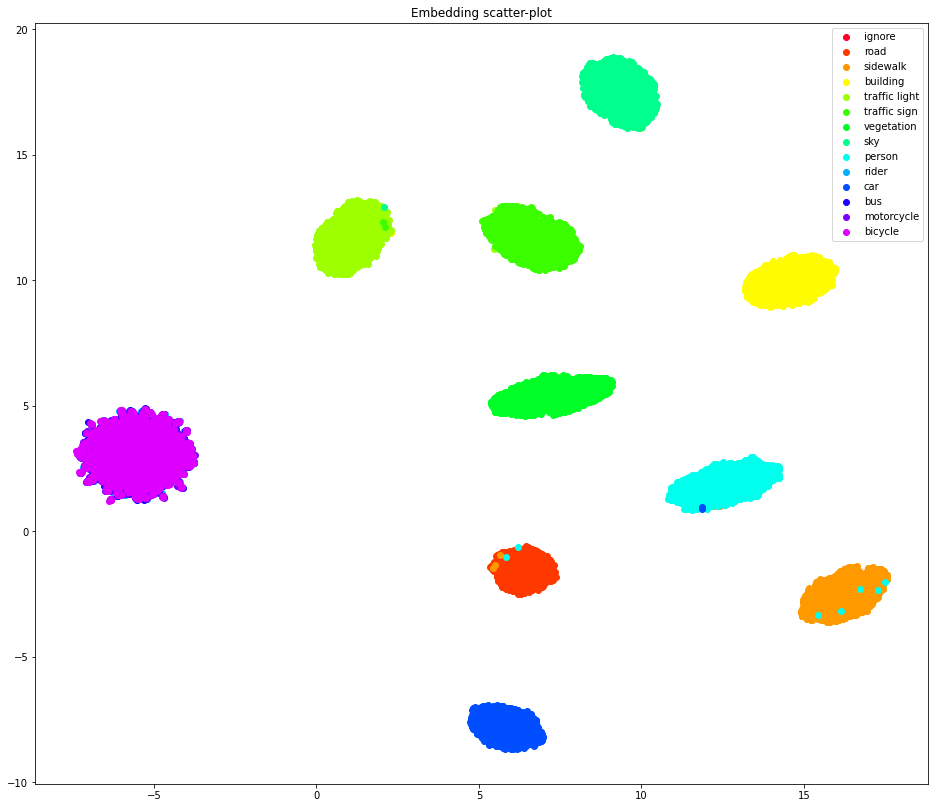

17.204325437545776


In [22]:
import data_utils_new
import matplotlib.pyplot as plt 
import umap.umap_ as umap
# Generate data from the gmm model and plot it

start_time = time.time()

n_samples = np.ones(num_classes, dtype=int)
n_samples[0] = 0
n_samples *= 2000

xx, yy = utils.sample_from_gaussians(means, covs, n_samples=n_samples)

NUM_COLORS = num_classes

reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(xx)

plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(data_utils_new.label_ids_13.keys())
idx = 0
for label in data_utils_new.label_ids_13:
    ind = yy == data_utils_new.label_ids_13[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()

print(time.time() - start_time)

In [11]:
deeplabv3.load_weights(fn_w_adapted_dlv3)
classifier.load_weights(fn_w_adapted_cls)
print("Loaded model weights")

Loaded model weights


In [12]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou('./processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/', combined_, data_utils.label_ids_13, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

road 0.8308608968675483
sidewalk 0.27348768244553456
building 0.6513443882341332
traffic light 0.37291672961621636
traffic sign 0.0038099773782593166
vegetation 0.16323353477649255
sky 0.888175399577542
person 0.19304997344212002
rider 0.0
car 0.8840926390088035
bus 0.0
motorcycle 0.0
bicycle 0.0
0.32776701702666533
Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 159.04997277259827

0
100
200
300
400
road 0.8308608968675483
sidewalk 0.27348768244553456
building 0.6513443882341332
traffic light 0.37291672961621636
traffic sign 0.0038099773782593166
vegetation 0.16323353477649255
sky 0.888175399577542
person 0.19304997344212002
rider 0.0
car 0.8840926390088035
bus 0.0
motorcycle 0.0
bicycle 0.0
0.32776701702666533
Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 159.04997277259827


In [ ]:
# road 0.8615069121641106
# sidewalk 0.9000754476234025
# building 0.9430840666603088
# traffic light 0.5906668306793044
# traffic sign 0.4751323753940848
# vegetation 0.8432769737226227
# sky 0.9643724556369807
# person 0.7238095621515034
# rider 0.6191529188583779
# car 0.8826804768268254
# bus 0.9113284943230776
# motorcycle 0.6885963930665517
# bicycle 0.3477612301913242
# 0.7501110874844981
# Computed SYNTHIA_VIPER_DENSE_13 mIoU in 209.03599977493286

# VIPER1
# road 0.7598092688219289
# sidewalk 0.3371948453270736
# building 0.5888429412251485
# traffic light 0.2412746294793218
# traffic sign 0.007871538466283783
# vegetation 0.07906209988581193
# sky 0.8681167733611675
# person 0.15913067911219309
# rider 0.0
# car 0.8381470531819963
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.2984192176046866
# Computed SYNTHIA_VIPER_DENSE_13_2 mIoU in 12.690653085708618

# VIPER2
# road 0.12746921970993438
# sidewalk 0.01654514397536747
# building 0.08359767761356621
# traffic light 0.0014628747427203985
# traffic sign 0.0004797761683849531
# vegetation 0.0010155479171658137
# sky 0.06442882520719335
# person 1.3905304873809358e-05
# rider 0.0
# car 0.013538577154181806
# bus 0.0040766048179061275
# motorcycle 0.0
# bicycle 0.0
# 0.024048319431638026
# Computed SYNTHIA_VIPER_DENSE_13_3 mIoU in 16.93789768218994



In [11]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed VIPER mIoU in', time.time() - start_time)

# road 0.7883116582422506
# sidewalk 0.6215464735885322
# building 0.751691007583865
# wall 0.3993120030432491
# fence 0.39173486089325144
# pole 0.302509334397975
# traffic light 0.3019573318279201
# traffic sign 0.38603017233885695
# vegetation 0.7792104073113252
# terrain 0.484321694588526
# sky 0.8323752669785053
# person 0.5206867614087272
# rider 0.2377222662760571
# car 0.8020324193022697
# truck 0.4754062370048565
# bus 0.593789975462107
# train 0.5966522990567177
# motorcycle 0.3119814031424603
# bicycle 0.47793033593638945
# 0.5292211530728338
# Computed CITYSCAPES mIoU in 232.43373942375183

0
100
200
300
400
road 0.16361121759652467
sidewalk 5.5880594346001465e-06
building 0.0537824356711514
traffic light 0.004082077289533864
traffic sign 0.0
vegetation 0.004795258655464463
sky 0.03790733322264466
person 0.0
rider 0.0
car 0.02297664564513909
bus 0.0
motorcycle 0.0
bicycle 0.0
0.022089273549222518
Computed VIPER mIoU in 8.972235918045044


In [ ]:
# NO ADAPTATION

# road 0.4343089698314718
# sidewalk 0.11156745414108413
# building 0.3455360124643591
# traffic light 0.13244824374732939
# traffic sign 0.020891181218774212
# vegetation 0.16245698445827797
# sky 0.7351399630612382
# person 0.18702045190416963
# rider 0.0
# car 0.8301180914913947
# bus 0.06320265566955835
# motorcycle 0.0
# bicycle 0.0
# 0.23251461599905057
# Computed VIPER mIoU in 94.76635837554932

# ALL IN ONE

# road 0.6900469076232928
# sidewalk 0.3999559532819935
# building 0.4477707606588546
# traffic light 0.14471677916664455
# traffic sign 0.005208014396949388
# vegetation 0.22113673614692125
# sky 0.8054719866917823
# person 0.20232922242992005
# rider 0.0
# car 0.7608467046022307
# bus 0.5757047777388474
# motorcycle 0.0
# bicycle 0.0
# 0.32716829559518745
# Computed VIPER mIoU in 133.14108419418335

# SYNTHIA-VIPER1
# road 0.8153079075418371
# sidewalk 0.3638901684131552
# building 0.6422570606708572
# traffic light 0.3448658440152766
# traffic sign 0.030519858531548108
# vegetation 0.11682109473012166
# sky 0.86401077761864
# person 0.18156178781292293
# rider 0.0
# car 0.8640675468674487
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.32486938816936983
# Computed VIPER mIoU in 12.139243841171265


# VIPER1-VIPER2
# road 0.588499111128223
# sidewalk 0.369365725539779
# building 0.6204748941380721
# traffic light 0.1665936557512192
# traffic sign 0.01265457278785601
# vegetation 0.043019551365977134
# sky 0.8271666403331733
# person 0.3732262212752325
# rider 0.0
# car 0.816343619490096
# bus 0.02369959332673774
# motorcycle 0.0
# bicycle 0.0
# 0.29546489116433583
# Computed VIPER mIoU in 11.642083406448364

# VIPER2-VIPER3
# road 0.14499194020624828
# sidewalk 0.010885014754372853
# building 0.052795147047877924
# traffic light 0.00418806705772967
# traffic sign 0.0018961732294710642
# vegetation 0.006274219959573628
# sky 0.06364095194179961
# person 0.0
# rider 0.0
# car 0.013660761584344825
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.022948636598570604
# Computed VIPER mIoU in 14.073742628097534



In [ ]:
deeplabv3.save_weights(fn_w_adapted_dlv3)
classifier.save_weights(fn_w_adapted_cls)

In [ ]:
deeplabv3.load_weights(fn_w_adapted_dlv3)
classifier.load_weights(fn_w_adapted_cls)